# Intro
Classification problem with data from a CNC Mill: https://www.kaggle.com/shasun/tool-wear-detection-in-cnc-mill

# Data Integration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from pprint import pprint

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, precision_recall_curve
from sklearn.metrics import matthews_corrcoef, plot_confusion_matrix, f1_score 
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, auc

In [2]:
#General table view to understand features
df_results = pd.read_csv('./data/train.csv')
df_results.head(10)

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,wax,6,4.0,unworn,yes,yes
1,2,wax,20,4.0,unworn,yes,yes
2,3,wax,6,3.0,unworn,yes,yes
3,4,wax,6,2.5,unworn,no,NaN
4,5,wax,20,3.0,unworn,no,NaN
5,6,wax,6,4.0,worn,yes,no
6,7,wax,20,4.0,worn,no,NaN
7,8,wax,20,4.0,worn,yes,no
8,9,wax,15,4.0,worn,yes,no
9,10,wax,12,4.0,worn,yes,no


**Objective:** predict tool_condition

Important inputs:
* feedrate (speed and tool characteristics)
* clamp_pressure (may influence vibrations, deformation and material retreat)

In [3]:
#Table of Experiment 1 to understand possible features
df_experiment1 = pd.read_csv('experiment_01.csv')
df_experiment1.head(100)

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process
0,198.0,0.000,0.00,198.0,0.0,0.000000,0.180,0.0207,329.0,2.77,...,0.524,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting
1,198.0,-10.800,-350.00,198.0,-13.6,-358.000000,-10.900,0.1860,328.0,23.30,...,-0.288,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep
2,196.0,-17.800,-6.25,196.0,-17.9,-0.000095,-8.590,0.1400,328.0,30.60,...,0.524,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep
3,194.0,-18.000,0.00,194.0,-17.9,-0.000095,-6.110,0.1300,327.0,30.30,...,-0.180,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep
4,193.0,-17.900,-18.80,192.0,-17.9,0.000095,-5.700,0.1140,328.0,30.50,...,0.226,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,159.0,-0.125,-62.50,159.0,0.0,0.000000,2.750,0.0531,326.0,5.49,...,18.200,8.490000e-01,320.0,120.0,1.630000e-01,12.0,1.0,21.0,6.0,Layer 1 Up
96,159.0,0.175,81.20,159.0,0.0,0.000000,0.975,0.0428,326.0,3.35,...,27.800,1.180000e+00,322.0,116.0,2.270000e-01,12.0,1.0,21.0,6.0,Layer 1 Up
97,159.0,0.000,-12.50,159.0,0.0,0.000000,1.640,0.0353,325.0,5.96,...,21.200,8.230000e-01,322.0,120.0,1.570000e-01,12.0,1.0,2.0,6.0,Layer 1 Up
98,159.0,0.050,25.00,159.0,0.0,0.000000,1.090,0.0586,326.0,4.13,...,21.500,8.000000e-01,317.0,118.0,1.530000e-01,12.0,1.0,21.0,6.0,Layer 1 Up


* Active machining operations are labeled as "Layer 1 Up", "Layer 1 Down", "Layer 2 Up", "Layer 2 Down", "Layer 3 Up", and "Layer 3 Down". Can I delete Starting, Prep, End? These phases have errors in tho informations.
* When M1_CURRENT_FEEDRATE = 50; X1_ActualPosition = 198 or M1_CURRENT_PROGRAM_NUMBER =! 0 these parameter are wrong

In [4]:
df_experiment1.describe()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_CommandAcceleration,S1_CurrentFeedback,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE
count,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,...,1.055000e+03,1055.000000,1.055000e+03,1055.00000,1055.000000,1055.000000,1055.0,1055.0,1055.000000,1055.000000
mean,151.998104,-0.514919,4.252891,151.999052,-0.516069,0.075188,-0.382762,0.081607,325.875829,10.755812,...,4.739336e-01,20.508831,9.017116e-01,320.18673,114.488227,0.171890,12.0,1.0,64.144076,8.669194
std,8.315984,5.875864,103.299534,8.309193,5.871274,81.316778,4.936649,0.030217,0.576857,6.354004,...,6.871208e+00,5.509617,2.162504e-01,2.65724,20.408309,0.037033,0.0,0.0,39.669174,10.508312
min,141.000000,-18.100000,-1090.000000,141.000000,-17.900000,-922.000000,-17.000000,0.016300,322.000000,0.130000,...,-9.540000e-07,-0.694000,2.740000e-19,306.00000,0.000000,-0.000001,12.0,1.0,0.000000,6.000000
25%,145.000000,-5.690000,-37.500000,145.000000,-5.770000,0.000000,-4.940000,0.061900,326.000000,5.885000,...,0.000000e+00,18.300000,8.375000e-01,318.00000,117.000000,0.159000,12.0,1.0,29.000000,6.000000
50%,151.000000,-0.050000,0.000000,151.000000,0.000000,0.000000,-1.100000,0.085800,326.000000,12.400000,...,0.000000e+00,21.000000,9.280000e-01,321.00000,118.000000,0.178000,12.0,1.0,65.000000,6.000000
75%,159.000000,4.140000,37.500000,159.000000,4.280000,0.000000,4.405000,0.099350,326.000000,14.000000,...,0.000000e+00,23.350000,9.950000e-01,322.00000,119.000000,0.191500,12.0,1.0,100.000000,6.000000
max,198.000000,44.900000,1030.000000,198.000000,44.700000,937.000000,19.000000,0.319000,329.000000,64.800000,...,1.000000e+02,62.000000,2.650000e+00,329.00000,129.000000,0.441000,12.0,1.0,132.000000,50.000000


In [5]:
frames = list()
for i in range(1,19):
    numb = '0' + str(i) if i < 10 else str(i)
    frame = pd.read_csv("experiment_{}.csv".format(numb))
    row = df_results[df_results['No'] == i]
    frame['clamp_pressure'] = row.iloc[0]['clamp_pressure']
    frame['tool_condition'] = row.iloc[0]['tool_condition']
    frames.append(frame)
df = pd.concat(frames, ignore_index = True)
df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,clamp_pressure,tool_condition
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,4.0,unworn
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,4.0,unworn
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,4.0,unworn
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,4.0,unworn
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,4.0,unworn


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25286 non-null  float64
 1   X1_ActualVelocity          25286 non-null  float64
 2   X1_ActualAcceleration      25286 non-null  float64
 3   X1_CommandPosition         25286 non-null  float64
 4   X1_CommandVelocity         25286 non-null  float64
 5   X1_CommandAcceleration     25286 non-null  float64
 6   X1_CurrentFeedback         25286 non-null  float64
 7   X1_DCBusVoltage            25286 non-null  float64
 8   X1_OutputCurrent           25286 non-null  float64
 9   X1_OutputVoltage           25286 non-null  float64
 10  X1_OutputPower             25286 non-null  float64
 11  Y1_ActualPosition          25286 non-null  float64
 12  Y1_ActualVelocity          25286 non-null  float64
 13  Y1_ActualAcceleration      25286 non-null  flo

**Features:**
* We won't add feedrate because we already have M1_CURRENT_FEEDRATE
* Keep only active machining data ("Layer 1 Up", "Layer 1 Down", "Layer 2 Up", "Layer 2 Down", "Layer 3 Up", and "Layer 3 Down")
* Add difference features (diff = Command - Actual)
* Deleting Command columns
* Deleting Machine_Process
* Dummy variable for tool_condition

## Feature Engineering

In [7]:
# Selecting only active machining data
df = df[(df.Machining_Process == 'Layer 1 Up') | (df.Machining_Process == 'Layer 1 Down') |
        (df.Machining_Process == 'Layer 2 Up') | (df.Machining_Process == 'Layer 2 Down') |
        (df.Machining_Process == 'Layer 3 Up') | (df.Machining_Process == 'Layer 3 Down')]
df

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,clamp_pressure,tool_condition
31,151.0,0.075,37.50,151.0,0.000,0.00,0.878,0.0377,327.0,1.56,...,318.0,44.9,0.1500,12.0,1.0,12.0,6.0,Layer 1 Up,4.0,unworn
32,151.0,-0.075,-37.50,151.0,0.000,0.00,0.664,0.0332,325.0,4.30,...,317.0,72.8,0.2310,12.0,1.0,14.0,6.0,Layer 1 Up,4.0,unworn
33,151.0,-6.000,6.25,150.0,-6.000,0.00,-8.100,0.0983,323.0,10.20,...,309.0,88.4,0.3410,12.0,1.0,14.0,6.0,Layer 1 Up,4.0,unworn
34,150.0,-6.150,-43.80,150.0,-6.000,0.00,-6.420,0.1010,322.0,11.50,...,306.0,109.0,0.4410,12.0,1.0,14.0,6.0,Layer 1 Up,4.0,unworn
35,149.0,-5.930,62.50,149.0,-6.000,0.00,-6.670,0.0980,325.0,14.20,...,324.0,112.0,0.0746,12.0,1.0,14.0,6.0,Layer 1 Up,4.0,unworn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25083,142.0,-0.525,87.50,142.0,-0.692,1.84,-3.430,0.0694,327.0,7.46,...,320.0,117.0,0.1400,12.0,1.0,2.0,3.0,Layer 3 Down,2.5,worn
25084,142.0,-0.350,81.20,142.0,-0.506,1.86,-4.680,0.0808,327.0,7.05,...,321.0,119.0,0.1890,12.0,1.0,98.0,3.0,Layer 3 Down,2.5,worn
25085,142.0,-0.075,106.00,142.0,-0.319,1.88,-4.470,0.0692,327.0,6.34,...,320.0,116.0,0.1810,12.0,1.0,98.0,3.0,Layer 3 Down,2.5,worn
25086,141.0,0.025,87.50,141.0,-0.131,1.89,-4.700,0.0806,327.0,7.02,...,321.0,118.0,0.1570,12.0,1.0,98.0,3.0,Layer 3 Down,2.5,worn


In [8]:
# Add difference features
df['X1_DiffPosition'] = df['X1_CommandPosition']-df['X1_ActualPosition']
df['X1_DiffVelocity'] = df['X1_CommandVelocity']-df['X1_ActualVelocity']
df['X1_DiffAcceleration'] = df['X1_CommandAcceleration']-df['X1_ActualAcceleration']
df['Y1_DiffPosition'] = df['Y1_CommandPosition']-df['Y1_ActualPosition']
df['Y1_DiffVelocity'] = df['Y1_CommandVelocity']-df['Y1_ActualVelocity']
df['Y1_DiffAcceleration'] = df['Y1_CommandAcceleration']-df['Y1_ActualAcceleration']
df['Z1_DiffPosition'] = df['Z1_CommandPosition']-df['Z1_ActualPosition']
df['Z1_DiffVelocity'] = df['Z1_CommandVelocity']-df['Z1_ActualVelocity']
df['Z1_DiffAcceleration'] = df['Z1_CommandAcceleration']-df['Z1_ActualAcceleration']
df['S1_DiffPosition'] = df['S1_CommandPosition']-df['S1_ActualPosition']
df['S1_DiffVelocity'] = df['S1_CommandVelocity']-df['S1_ActualVelocity']
df['S1_DiffAcceleration'] = df['S1_CommandAcceleration']-df['S1_ActualAcceleration']
df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,X1_DiffAcceleration,Y1_DiffPosition,Y1_DiffVelocity,Y1_DiffAcceleration,Z1_DiffPosition,Z1_DiffVelocity,Z1_DiffAcceleration,S1_DiffPosition,S1_DiffVelocity,S1_DiffAcceleration
31,151.0,0.075,37.50,151.0,0.0,0.0,0.878,0.0377,327.0,1.56,...,-37.50,0.0,-0.025,-6.25,-0.1,-0.12,25.0,0.0,0.8,1.700000
32,151.0,-0.075,-37.50,151.0,0.0,0.0,0.664,0.0332,325.0,4.30,...,37.50,0.0,0.075,31.30,0.0,3.13,790.5,0.0,0.7,11.500000
33,151.0,-6.000,6.25,150.0,-6.0,0.0,-8.100,0.0983,323.0,10.20,...,-6.25,0.0,-0.050,-25.00,0.0,0.00,0.0,1.0,0.7,1.100000
34,150.0,-6.150,-43.80,150.0,-6.0,0.0,-6.420,0.1010,322.0,11.50,...,43.80,0.0,-0.050,-18.80,0.0,0.00,0.0,1.0,0.7,-25.000000
35,149.0,-5.930,62.50,149.0,-6.0,0.0,-6.670,0.0980,325.0,14.20,...,-62.50,0.0,0.100,50.00,0.0,0.00,0.0,0.0,-0.4,50.999999


In [9]:
# dropping redundant features and Machining_Process
drop_cols = ['X1_CommandPosition', 'X1_CommandVelocity', 'X1_CommandAcceleration', 'Y1_CommandPosition',
            'Y1_CommandVelocity', 'Y1_CommandAcceleration', 'Z1_CommandPosition', 'Z1_CommandVelocity',
            'Z1_CommandAcceleration', 'S1_CommandPosition', 'S1_CommandVelocity', 'S1_CommandAcceleration',
            'Machining_Process']
df = df.drop(drop_cols, axis=1)

In [10]:
#creating a dummy variable for tool_conditions
dummies = pd.get_dummies(df.tool_condition)
dummies

,unworn,worn
31,1,0
32,1,0
33,1,0
34,1,0
35,1,0
...,...,...
25083,0,1
25084,0,1
25085,0,1
25086,0,1


In [11]:
df = pd.concat([df, dummies], axis='columns')

In [12]:
#dropping redundant features
df = df.drop(['unworn', 'tool_condition'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17520 entries, 31 to 25087
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          17520 non-null  float64
 1   X1_ActualVelocity          17520 non-null  float64
 2   X1_ActualAcceleration      17520 non-null  float64
 3   X1_CurrentFeedback         17520 non-null  float64
 4   X1_DCBusVoltage            17520 non-null  float64
 5   X1_OutputCurrent           17520 non-null  float64
 6   X1_OutputVoltage           17520 non-null  float64
 7   X1_OutputPower             17520 non-null  float64
 8   Y1_ActualPosition          17520 non-null  float64
 9   Y1_ActualVelocity          17520 non-null  float64
 10  Y1_ActualAcceleration      17520 non-null  float64
 11  Y1_CurrentFeedback         17520 non-null  float64
 12  Y1_DCBusVoltage            17520 non-null  float64
 13  Y1_OutputCurrent           17520 non-null  fl

# EDA

In [13]:
#Understanding the features's distributions

def multi_plot(data, figsizes, cols, shareys=True,colors='red'):
    ref = 0 
    rows = round(len(data.columns)/cols)
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsizes, sharey=shareys, squeeze=True)

    for n in range(cols):
        for x in range(rows):
            axs[x, n].set_title(data.columns[ref])
            axs[x, n].hist(data[data.columns[ref]], color=colors)
            ref += 1
           
    return plt.show()        

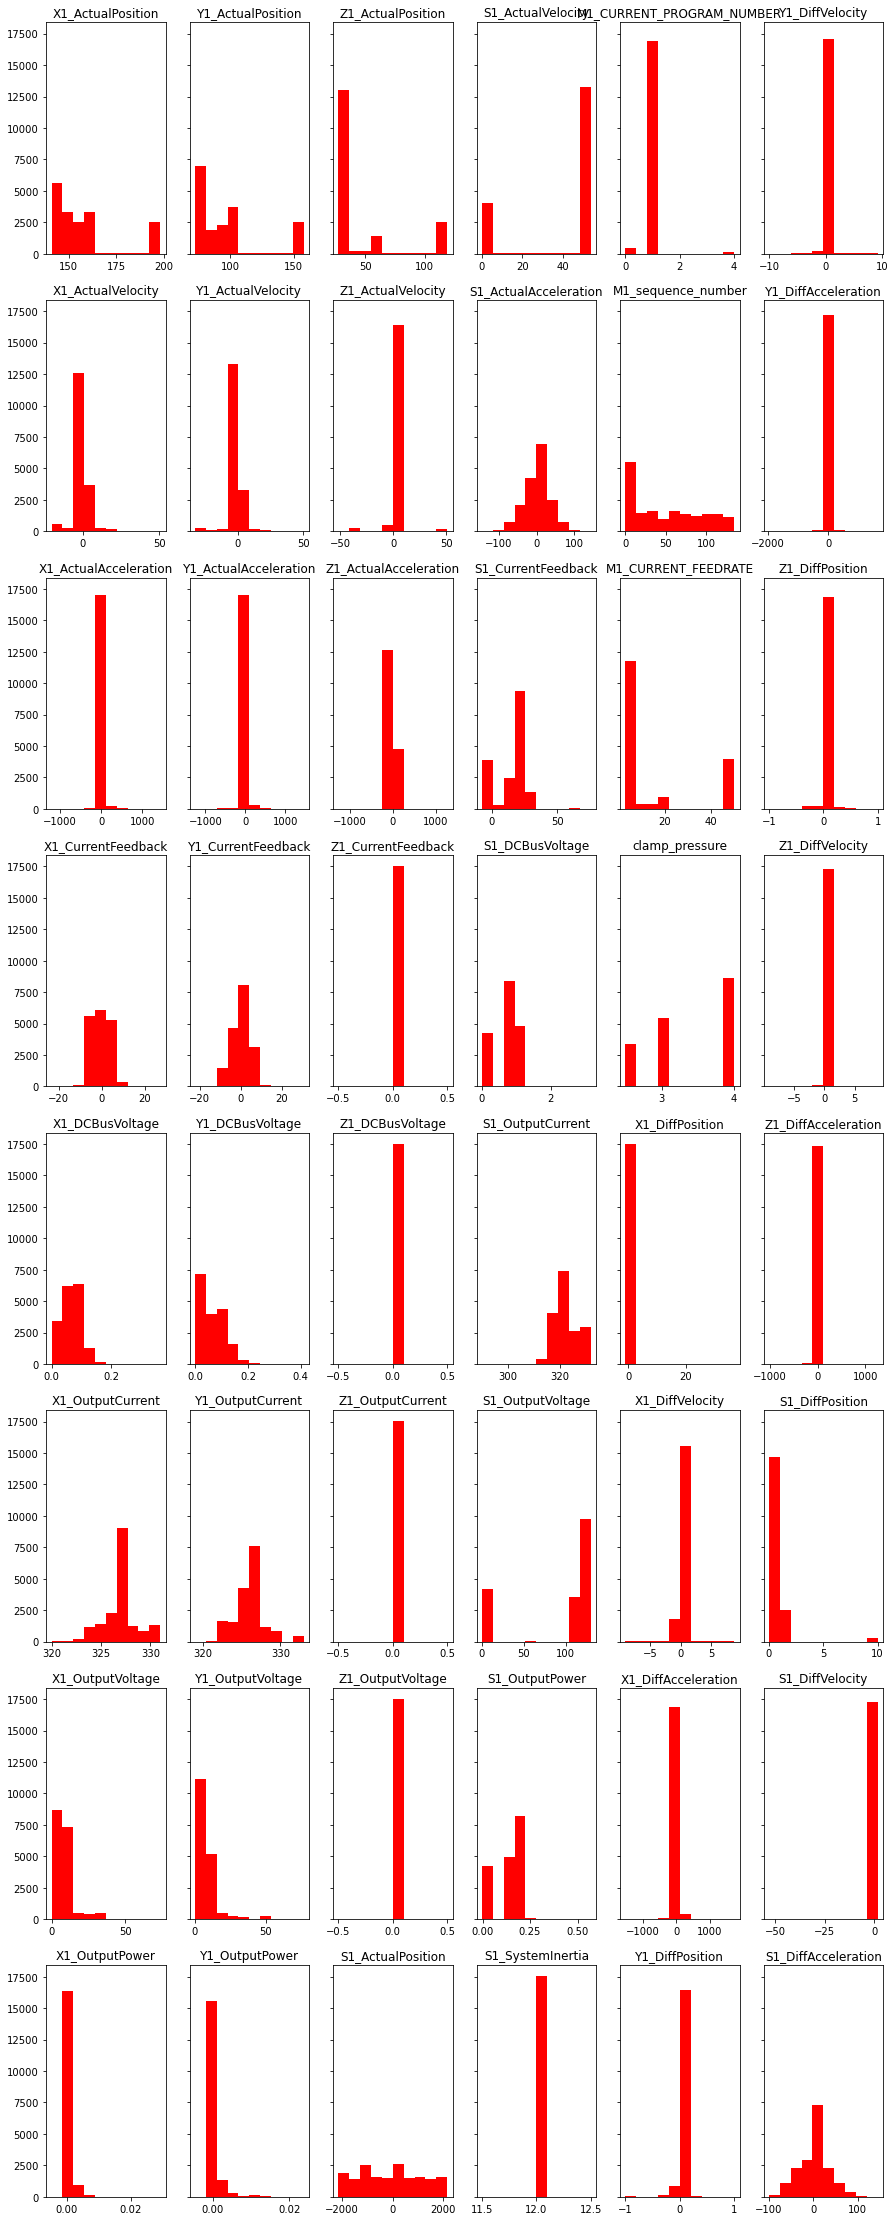

In [14]:
multi_plot(data=df, figsizes=(15, 40), cols=6)

**Variables to be better explored**
* S1_SystemInertia
* S1_DiffVelocity
* Z1_OutputVoltage
* Z1_OutputCurrent
* X1_DiffPosition
* Z1_DCBusVoltage
* Z1_CurrentFeedback
* Z1_DiffAcceleration

**There are other features that are almost constant, should they be considered bad predictors as well?:**
* Z1_DiffVelocity
* X1_DiffAcceleration

In [15]:
df.loc[:, ['S1_SystemInertia', 'S1_DiffVelocity', 'Z1_OutputVoltage',
          'Z1_OutputCurrent', 'X1_DiffPosition', 'Z1_DCBusVoltage',
          'Z1_CurrentFeedback', 'Z1_DiffAcceleration']].describe()

,S1_SystemInertia,S1_DiffVelocity,Z1_OutputVoltage,Z1_OutputCurrent,X1_DiffPosition,Z1_DCBusVoltage,Z1_CurrentFeedback,Z1_DiffAcceleration
count,17520.0,17520.000000,17520.0,17520.0,17520.000000,17520.0,17520.0,17520.000000
mean,12.0,-0.366218,0.0,0.0,-0.000685,0.0,0.0,0.253279
std,0.0,3.425786,0.0,0.0,0.319826,0.0,0.0,38.523092
min,12.0,-53.200000,0.0,0.0,-1.000000,0.0,0.0,-1019.000000
25%,12.0,-0.100000,0.0,0.0,0.000000,0.0,0.0,-6.250000
50%,12.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
75%,12.0,0.000000,0.0,0.0,0.000000,0.0,0.0,6.250000
max,12.0,1.610000,0.0,0.0,37.000000,0.0,0.0,1260.000000


Some features have constant behaviour therefere will be dropped. S1_DiffVelocity, Z1_DiffAcceleration and X1_DiffPosition have a few different values so they won't be excluded

In [16]:
drop_cols = ['S1_SystemInertia', 'Z1_OutputVoltage', 'Z1_OutputCurrent',
            'Z1_DCBusVoltage', 'Z1_CurrentFeedback']
df = df.drop(drop_cols, axis=1)
df 

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,X1_OutputPower,Y1_ActualPosition,Y1_ActualVelocity,...,Y1_DiffPosition,Y1_DiffVelocity,Y1_DiffAcceleration,Z1_DiffPosition,Z1_DiffVelocity,Z1_DiffAcceleration,S1_DiffPosition,S1_DiffVelocity,S1_DiffAcceleration,worn
31,151.0,0.075,37.50,0.878,0.0377,327.0,1.56,0.000008,73.0,0.025,...,0.0,-0.025,-6.2500,-0.1,-0.120,25.00,0.0,0.8,1.700000,0
32,151.0,-0.075,-37.50,0.664,0.0332,325.0,4.30,0.000004,73.0,-0.075,...,0.0,0.075,31.3000,0.0,3.130,790.50,0.0,0.7,11.500000,0
33,151.0,-6.000,6.25,-8.100,0.0983,323.0,10.20,0.001260,73.0,0.050,...,0.0,-0.050,-25.0000,0.0,0.000,0.00,1.0,0.7,1.100000,0
34,150.0,-6.150,-43.80,-6.420,0.1010,322.0,11.50,0.001260,73.0,0.050,...,0.0,-0.050,-18.8000,0.0,0.000,0.00,1.0,0.7,-25.000000,0
35,149.0,-5.930,62.50,-6.670,0.0980,325.0,14.20,0.001180,73.0,-0.100,...,0.0,0.100,50.0000,0.0,0.000,0.00,0.0,-0.4,50.999999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25083,142.0,-0.525,87.50,-3.430,0.0694,327.0,7.46,0.000062,76.6,2.900,...,0.1,0.020,-12.0620,0.0,0.025,6.25,1.0,-0.2,-82.100000,1
25084,142.0,-0.350,81.20,-4.680,0.0808,327.0,7.05,0.000089,76.9,2.830,...,0.1,0.130,12.8210,0.0,0.025,12.50,0.0,0.1,56.700000,1
25085,142.0,-0.075,106.00,-4.470,0.0692,327.0,6.34,0.000021,77.2,2.720,...,0.1,0.260,44.0040,0.0,0.025,12.50,1.0,-0.1,-20.500000,1
25086,141.0,0.025,87.50,-4.700,0.0806,327.0,7.02,0.000063,77.5,2.780,...,0.1,0.220,87.5848,0.0,0.000,0.00,1.0,-0.1,-1.059999,1


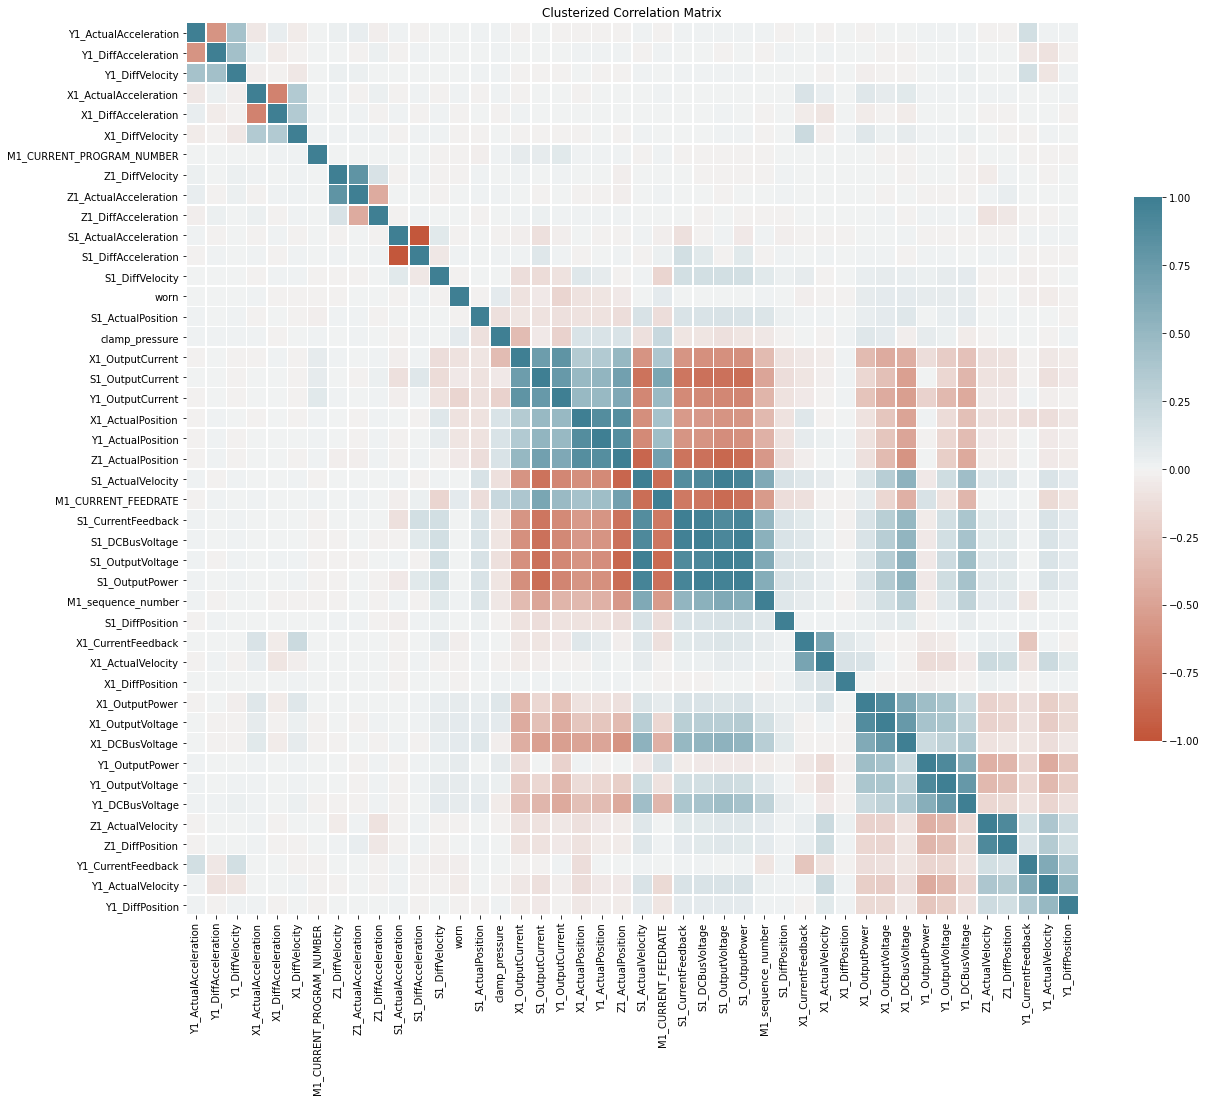

In [17]:
# Creating a clusterized correlation matrix for better understanding the relationships between features

df_corr = df.corr()
dissimilarity = 1 - abs(df_corr)
Z = linkage(squareform(dissimilarity), 'complete')
# Clusterize the data
threshold = 0.4
labels = fcluster(Z, threshold, criterion='distance')

# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df[i])
    else:
        df_to_append = pd.DataFrame(df[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)
# Plotando
plt.figure(figsize=(20,20))
correlations = clustered.corr()
sns.heatmap(round(correlations,2),
            cmap=sns.diverging_palette(20, 220, n=200), 
            square=True, 
            annot=False, 
            linewidths=.5,
            vmin=-1, vmax=1, center= 0,
            cbar_kws={"shrink": .5})
plt.title("Clusterized Correlation Matrix")
plt.yticks(rotation=0)
plt.show()

In [18]:
# Multicolinearity test
X = add_constant(df)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const                        153580.574651
X1_ActualPosition                 8.822878
X1_ActualVelocity                 2.676311
X1_ActualAcceleration            11.251398
X1_CurrentFeedback                2.667658
X1_DCBusVoltage                   3.804501
X1_OutputCurrent                  4.728053
X1_OutputVoltage                  8.340475
X1_OutputPower                    7.451250
Y1_ActualPosition                 6.467584
Y1_ActualVelocity                 2.812256
Y1_ActualAcceleration             8.495503
Y1_CurrentFeedback                2.257799
Y1_DCBusVoltage                   3.722163
Y1_OutputCurrent                  4.779360
Y1_OutputVoltage                 12.727777
Y1_OutputPower                    9.978770
Z1_ActualPosition                30.145437
Z1_ActualVelocity                 6.062529
Z1_ActualAcceleration            33.158356
S1_ActualPosition                 1.044421
S1_ActualVelocity               794.993675
S1_ActualAcceleration           175.080518
S1_CurrentF

We have many features with VIF > 10, for now we are going to bold them here and later see their importance as features in our models to decide wheter dropping them or not.
* X1_ActualAcceleration
* Y1_OutputVoltage
* Z1_ActualPosition
* Z1_ActualAcceleration
* **S1_ActualVelocity**
* **S1_ActualAcceleration**
* S1_CurrentFeedback
* **S1_DCBusVoltage**
* **S1_OutputVoltage**
* **S1_OutputPower**
* X1_DiffAcceleration
* Z1_DiffVelocity
* Z1_DiffAcceleration 
* S1_DiffVelocity
* **S1_DiffAcceleration**

**Questions**
* Should I immediately delete every feature that has VIF>10? Or VIF>50 at least?
* Which further analysis could complement VIF for feature selection?

# Models

In [19]:
# Should I scale the features before proceeding???
# Should I convert the dataframes to np.array?

# Creating initial features' dataframe and label's dataframe

y = df['worn']
x = df.drop(['worn'], axis=1)

In [20]:
# random_state what is that?
# Test/train split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## Decision Tree

In [21]:
#Creating the decision tree model
classifier = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
classifier.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=0)

In [22]:
#Prediction of Y values
Y_pred = classifier.predict(X_test)

In [23]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[1572   40]
 [  52 1840]]
Accuracy:  0.9737
F1 Score:  0.9756
MCC 0.9472


 * **Accuracy:** since our data is not spread (split ~ 54%w/46%uw) this is a good indicator
 * **F1 Score:** balance between precision (% of true positives in all positives) and recall (% of positives correctly classified) 
 * **MCC:** is good for very spread data and works like a correlation index (from -1 to +1)

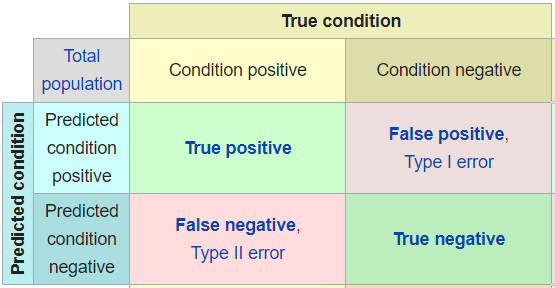

### Feature Selection

In [24]:
# First we need to calculate the relative importance of our features
# Get numerical feature importances
importances = list(classifier.feature_importances_)

# Saving feature names for later use
feature_list = list(x.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Z1_ActualPosition    Importance: 0.6684
Variable: Y1_OutputCurrent     Importance: 0.105
Variable: X1_DCBusVoltage      Importance: 0.0382
Variable: X1_OutputCurrent     Importance: 0.0348
Variable: S1_ActualPosition    Importance: 0.0254
Variable: Z1_ActualVelocity    Importance: 0.0188
Variable: clamp_pressure       Importance: 0.0157
Variable: Y1_CurrentFeedback   Importance: 0.0106
Variable: X1_OutputPower       Importance: 0.0104
Variable: Y1_DCBusVoltage      Importance: 0.0095
Variable: M1_CURRENT_FEEDRATE  Importance: 0.0094
Variable: Y1_DiffAcceleration  Importance: 0.0073
Variable: X1_ActualPosition    Importance: 0.0063
Variable: X1_ActualVelocity    Importance: 0.0054
Variable: S1_OutputCurrent     Importance: 0.0049
Variable: S1_CurrentFeedback   Importance: 0.0029
Variable: X1_OutputVoltage     Importance: 0.0028
Variable: Y1_ActualPosition    Importance: 0.0025
Variable: X1_CurrentFeedback   Importance: 0.0023
Variable: Y1_OutputPower       Importance: 0.0022
V

In [25]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

We will only use the features necessary for 95% of information. That's an arbitrary treshold

In [26]:
# Find number of features for cumulative importance of 95%
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 12


In [27]:
# We will keep only the 12 first features from our list, meaning that we need to drop all the others
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:12]]

# Test/train split
# Create training and testing sets with only the important features
X_dt_train = X_train.loc[:, important_feature_names]
X_dt_test = X_test.loc[:, important_feature_names]

In [28]:
#Creating the decision tree model with only the most important features
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
dt.fit(X_dt_train, Y_train)

DecisionTreeClassifier(random_state=0)

In [29]:
#Prediction of Y values
Y_pred = dt.predict(X_dt_test)

In [30]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[1580   32]
 [  27 1865]]
Accuracy:  0.9832
F1 Score:  0.9844
MCC 0.9661


In [ ]:
# Calculate VIF for this new feature dataset

### Hyperparameters Tuning

In [31]:
# Look at parameters used by our current tree
print('Parameters currently in use:\n')
pprint(dt.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 0,
 'splitter': 'best'}


In [32]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
max_features.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 12]
# The function to measure the quality of a split.
criterion = ['gini', 'entropy']
    
# How to tune these parameters with reasonable data????

# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}
pprint(random_grid)

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4, 8, 12],
 'min_samples_split': [2, 4, 6, 8, 10]}


In [33]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=random_grid,
                               n_iter=200, cv=5, verbose=2, random_state=0, n_jobs=-1)

# Fit the random search model
dt_fit = dt_random.fit(X_dt_train, Y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:   11.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.9s finished


In [34]:
#Parameter from fitting
dt_random.best_params_

{'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 80,
 'criterion': 'entropy'}

Best parameters tested

{'min_samples_split': 4,

 'min_samples_leaf': 1,
 
 'max_features': None,
 
 'max_depth': 80,
 
 'criterion': 'entropy'}

In [94]:
#Training tuned decision tree
Y_pred = dt_random.best_estimator_.predict(X_dt_test)

#dt = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf=1, max_features=None,
#                            max_depth=80, criterion='entropy')
#dt.fit(X_dt_train, Y_train)
#Y_pred = dt.predict(X_dt_test)

In [95]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[1598   14]
 [  23 1869]]
Accuracy:  0.9894
F1 Score:  0.9902
MCC 0.9788


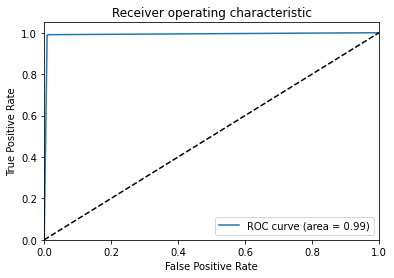

In [37]:
#ROC curve calculations
Y_test_score = dt_fit.predict_proba(X_dt_test)[:, 1]

def plot_roc_curve(y_test, y_test_score):
 
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(Y_test, Y_test_score)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.99')

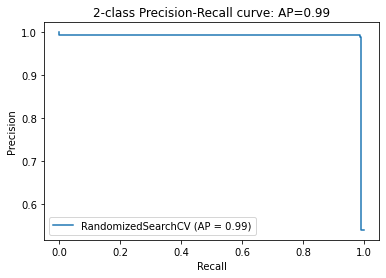

In [38]:
#Calculating average precision score
average_precision = average_precision_score(Y_test, Y_test_score)

#Plotting precision-recall curve
disp = plot_precision_recall_curve(dt_fit, X_dt_test, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Random Forest

In [39]:
#Creating the Random Forest Model
classifier_rf = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0)
classifier_rf.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [40]:
#Prediction of Y values
Y_pred = classifier_rf.predict(X_test)

In [41]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[1576   36]
 [  15 1877]]
Accuracy:  0.9854
F1 Score:  0.9866
MCC 0.9707


### Feature Selection

In [42]:
#First, we will try a random forest algo using the features choosen previously by the decision tree:
rf = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0)
rf.fit(X_dt_train, Y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [43]:
#Prediction of Y values
Y_pred = rf.predict(X_dt_test)

In [44]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[1587   25]
 [  13 1879]]
Accuracy:  0.9892
F1 Score:  0.99
MCC 0.9782


In [45]:
#Our performance indicators are slightly better, with much less features. 
#But we will try reprioritize the features using a Random Forest model

# First we need to calculate the relative importance of our features
# Get numerical feature importances
importances = list(classifier_rf.feature_importances_)

# Saving feature names for later use
feature_list = list(x.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Z1_ActualPosition    Importance: 0.3065
Variable: X1_OutputCurrent     Importance: 0.0614
Variable: M1_sequence_number   Importance: 0.0604
Variable: S1_ActualPosition    Importance: 0.0473
Variable: Y1_OutputCurrent     Importance: 0.046
Variable: S1_OutputCurrent     Importance: 0.0301
Variable: M1_CURRENT_FEEDRATE  Importance: 0.0288
Variable: X1_DCBusVoltage      Importance: 0.0258
Variable: X1_OutputVoltage     Importance: 0.0255
Variable: clamp_pressure       Importance: 0.0249
Variable: Y1_DCBusVoltage      Importance: 0.0236
Variable: Y1_OutputVoltage     Importance: 0.02
Variable: S1_CurrentFeedback   Importance: 0.0197
Variable: X1_OutputPower       Importance: 0.0179
Variable: Y1_ActualPosition    Importance: 0.015
Variable: X1_ActualVelocity    Importance: 0.0133
Variable: X1_CurrentFeedback   Importance: 0.0131
Variable: S1_OutputPower       Importance: 0.0127
Variable: X1_DiffAcceleration  Importance: 0.0126
Variable: Z1_DiffAcceleration  Importance: 0.0126
Vari

In [46]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# We will maintain our treshold of 95% importance, like the decision tree feature selection

# Find number of features for cumulative importance of 95%
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 33


In [47]:
# We will keep only the 12 first features from our list, meaning that we need to drop all the others
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:12]]

# Test/train split
# Create training and testing sets with only the important features
X_rf_train = X_train.loc[:, important_feature_names]
X_rf_test = X_test.loc[:, important_feature_names]

In [48]:
#Creating the Random Forest Model
rf = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0)
rf.fit(X_rf_train, Y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [49]:
#Prediction of Y values
Y_pred = rf.predict(X_rf_test)

In [50]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[1601   11]
 [  10 1882]]
Accuracy:  0.994
F1 Score:  0.9945
MCC 0.9879


### Hyperparameter Tuning

In [51]:
# Look at parameters used by our random forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [52]:
# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(200, 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
max_features.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# The function to measure the quality of a split.
criterion = ['gini', 'entropy']
# Method of selecting samples for training each tree
bootstrap = [True, False]
    
# How to tune these parameters with reasonable data????

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt', None],
 'min_samples_leaf': [1, 2, 4, 8],
 'min_samples_split': [2, 4, 6, 8],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [54]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)

# Fit the random search model
rf_fit = rf_random.fit(X_rf_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.7min finished


In [55]:
#Parameter from fitting
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'entropy',
 'bootstrap': False}

In [56]:
#Training tuned decision tree
Y_pred = rf_random.best_estimator_.predict(X_rf_test)

In [57]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[1603    9]
 [  10 1882]]
Accuracy:  0.9946
F1 Score:  0.995
MCC 0.9891


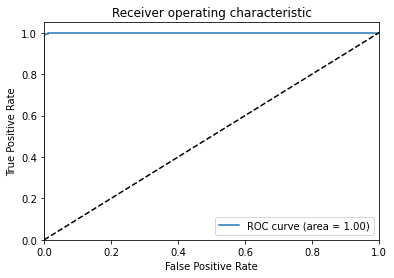

In [60]:
#ROC curve calculations
Y_test_score = rf_fit.predict_proba(X_rf_test)[:, 1]

def plot_roc_curve(y_test, y_test_score):
 
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(Y_test, Y_test_score)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

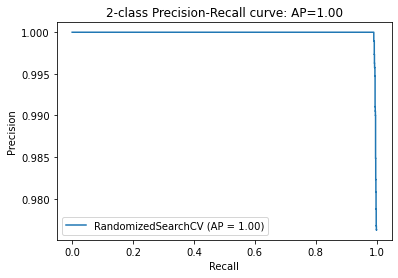

In [62]:
#Calculating average precision score
average_precision = average_precision_score(Y_test, Y_test_score)

#Plotting precision-recall curve
disp = plot_precision_recall_curve(rf_fit, X_rf_test, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

**Ways to improve performance:**
* Use Grid Search in a smaller set of hyperparameters
* Try Bayesian Optimization

## Logistic Regression

In [63]:
#Feature Scalling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [64]:
#Creating the Logistic Regression Model
classifier = LogisticRegression(random_state = 0, max_iter=200)
classifier.fit(X_train, Y_train)

LogisticRegression(max_iter=200, random_state=0)

In [65]:
#Prediction of Y values
Y_pred = classifier.predict(X_test)

In [66]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[ 746  866]
 [ 636 1256]]
Accuracy:  0.5713
F1 Score:  0.6258
MCC 0.1291


### Feature Selection

In [67]:
#Feature Scalling
sc = StandardScaler()
X_dt_train = sc.fit_transform(X_dt_train)
X_dt_test = sc.transform(X_dt_test)

In [68]:
lr = LogisticRegression(random_state = 0, max_iter=200)
classifier.fit(X_dt_train, Y_train)

LogisticRegression(max_iter=200, random_state=0)

In [69]:
#Prediction of Y values
Y_pred = classifier.predict(X_dt_test)

In [70]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[ 771  841]
 [ 710 1182]]
Accuracy:  0.5574
F1 Score:  0.6038
MCC 0.1039


In [71]:
#As the first try had a reduction in overall performance, we will try to use the Random Forest Features
#Feature Scalling
sc = StandardScaler()
X_rf_train = sc.fit_transform(X_rf_train)
X_rf_test = sc.transform(X_rf_test)

In [72]:
lr = LogisticRegression(random_state = 0, max_iter=200)
lr.fit(X_rf_train, Y_train)

LogisticRegression(max_iter=200, random_state=0)

In [73]:
#Prediction of Y values
Y_pred = lr.predict(X_rf_test)

In [74]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[ 727  885]
 [ 702 1190]]
Accuracy:  0.5471
F1 Score:  0.5999
MCC 0.0811


### Different feature scalling with best features dataset

In [76]:
# Using minmax scalling
# Normalizing continuous variables from the best features database (first one)

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_lr_train = scaler.transform(X_train)
X_lr_test = scaler.transform(X_test)

In [78]:
lr = LogisticRegression(random_state = 0, max_iter=300)
lr.fit(X_lr_train, Y_train)

LogisticRegression(max_iter=300, random_state=0)

In [79]:
#Prediction of Y values
Y_pred = lr.predict(X_lr_test)

In [80]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[ 724  888]
 [ 653 1239]]
Accuracy:  0.5602
F1 Score:  0.6166
MCC 0.1061


### Hyperparameter Tunning

In [85]:
param_grid = {'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

In [86]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lr = LogisticRegression(max_iter=300)

# Random search of parameters, using 5 fold cross validation, 
# search across different combinations, and use all available cores
gs = GridSearchCV(estimator=lr, param_grid=param_grid,
                  cv=5, verbose=True, n_jobs=-1)

# Fit the random search model
lr_fit = gs.fit(X_train, Y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


In [87]:
#Parameter from fitting
gs.best_params_

{'C': 1438.44988828766, 'penalty': 'l2', 'solver': 'liblinear'}

In [88]:
#Training tuned decision tree
Y_pred = gs.best_estimator_.predict(X_test)

In [89]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print(cm)
print('Accuracy: ', round(accuracy_score(Y_test, Y_pred), ndigits=4))
print('F1 Score: ', round(f1_score(Y_test, Y_pred), ndigits=4))
print('MCC', round(matthews_corrcoef(Y_test, Y_pred), ndigits=4))

Confusion Matrix
[[ 748  864]
 [ 623 1269]]
Accuracy:  0.5756
F1 Score:  0.6306
MCC 0.1376


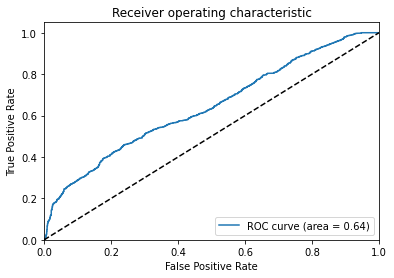

In [91]:
#ROC curve calculations
Y_test_score = lr_fit.predict_proba(X_test)[:, 1]

def plot_roc_curve(y_test, y_test_score):
 
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(Y_test, Y_test_score)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.69')

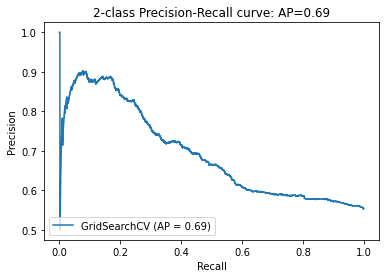

In [93]:
#Calculating average precision score
average_precision = average_precision_score(Y_test, Y_test_score)

#Plotting precision-recall curve
disp = plot_precision_recall_curve(lr_fit, X_test, Y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))